# Classification - Practical

Most common supervised learning tasks are regression (predicting values) and classification (predicting classes). First we will deal with the classification systems.

For this purpose, we will be using an MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. We will use the Scikit-learn to download this dataset.

In [62]:
# For eliminating warning messages, since Scikit-learn forces warnings a lot
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")

In general, datasets loaded by Scikit-learn have a similar dictionary structure including:

- A DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels

In [63]:
X, y = mnist["data"], mnist["target"]

In [64]:
X.shape

(70000, 784)

In [65]:
y.shape

(70000,)

There are 70,000 images and each image has 784 features. This is because each image is $28 \times 28$ pixels, and each feature simply represents one pixel's intensity, from $0$ (white) to $255$ (black). Let's look at one of the images from the MNIST.

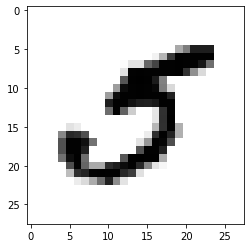

In [66]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")

In [67]:
y[36000]

5.0

We can see from this one instance that it resembles number 5 and the target confirms it.

Before we do any machine learning, we always need to create a test set and set it aside before inspecting the data closely. By loading the dataset with Scikit-learn, it already is split into training and test set:

In [68]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

We will also shuffle the training set, which will guarantee that all cross-validation folds will be similar. Moreover, some learning algorithms are sensitive to the order of training instances, and they perform poorly if they get many similar instances in a row.

**Note**: Sometimes shuffling isn't a good idea in some contexts - for example, if we work on a time series dataset.

In [69]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

For now, we will simplify the problem and only try to identify one digit - the digit 5. The "5-detector" will be an example of a _binary classifier_, capable of distinguishing between just two classes, 5 and not-5. We create the target vectors:

In [70]:
y_train_5 = (y_train == 5) # Which is True for all 5s and False otherwise
y_test_5 = (y_test == 5)

We will start with the _Stochastic Gradient Descent_ (SGD) classifier. This classifier is capable of handling very large datasets efficiently and is suited for _online learning_.

In [71]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

Let's see how it can be used to detect the images of number 5:

In [72]:
sgd_clf.predict([some_digit])

array([ True])

This classifier guesses that this image represents a $5$, which guessed it right. But we are interested in how it performs on other images

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor. There are, of course, many measures available.

A good way to evaluate a model is to use cross-validation. We will use the $cross\_val\_score()$ function to evaluate our SGDCLassifier model using K-fold cross-validation, with K being 3.

In [73]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96335, 0.9663 , 0.9625 ])

It looks amazing that we have achieved over $95\%$ on all cross-validation folds, but let's look at a very dumb classifier that just classifies every single image in the "not-5" class:

In [74]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [75]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91155, 0.9086 , 0.9088 ])

We have achieved over $90\%$ accuracy. The reason being is because only $10\%$ of the images are $5$s, which means if we only guess that an image is _not a 5_, we would be right about $90\%$ of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when we are dealing with _skewed datasets_ (this just means when some classes are much more frequent than the others).

A better way to evaluate the performance of a classifier is to look at the _confusion matrix_. The general idea is to count the number of times the classifier confused images of $5$s with $3$s, you would look in the $5^{th}$ row and $3^{rd}$ column of the confusion matrix.

For computing the confusion matrix, first we need to have a set of predictions, so they can be compared to actual targets.

In [76]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the $cross\_val\_score()$ function, $cross\_val\_predict()$ performs $K$-fold cross-validation, but instead of running evaluation errors, it returns the predictions made on each validation fold. This means we get a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by the model that never saw the data during training).

Now we are ready to get the confusion matrix using the $confusion\_matrix()$ function.

In [77]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[54100,   479],
       [ 1678,  3743]])

Each row in a confusion matrix represents an _actual class_, while each column represents a _predicted class_. In this case, the first row of this matrix considers non-5 images (the negative class): 54169 of them were correctly classified as non-5s (_true negatives_), while the remaining 410 were wrongly classified as 5s (_false positives_). The second row considers the images of 5s (_the positive class_): 1859 were wrongly classified as non-5s (_false negatives_) while the remaining 3562 were correctly classified as 5s (_true positives_). 

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have non-zero values only on its main diagonal.

The confusion matrix gives us a lot of information, but sometimes we prefer more concise metric, such as the _precision_ of the classifier, which is the accuracy of the positive predictions.

$$\text{precision} = \frac{TP}{TP + FP}$$

$TP$ is the number of true positives, while $FP$ represents number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = $\frac{1}{1} = 100\%$). This would not be very useful since the classifier would ignore all but one positive instance. So precision is typically used along with another metric called _recall_, also known as _sensitivity_ or _true positive rate (TPR)_. _Recall_ represents the ratio of positive instances that are correctly detected by the classifier.

$$recall = \frac{TP}{TP + FN}$$

$FN$ means the number of _false negatives_.

TODO: Draw some examples for precision and recall

In [78]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # 3562 / (3562 + 410) 

0.8865466603505447

In [79]:
recall_score(y_train_5, y_train_pred) # 3562 / (3562 + 1859)

0.6904630142040215

This means when a classifier claims an image represents a 5, it is correct only 89% of the time. Moreover, it only detects 65% of the 5s, which is not as great as we initially thought.

It is often convenient to combine precision and recall into a single metric called the $F_1$ _score_, in particular if we need a simple way to compare two classifiers. The $F_1$ score is the _harmonic mean_ of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high.

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [80]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7763144249714818

The $F_1$ score favors classifiers that have similar precision and recall. This is not what we always want: in some cases, we mostly care about precision, while in some other cases we care about recall. For example, if we trained a classifier to detect videos that are safe for kids, we would probably prefer a classifier that rejects many good videos (low recall), but keeps only the safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in our product. On the other hand, suppose we train a classifier to detect shoplifters on surveillance images: it is probably fine if our classifier has only 30% precision, but has over 99% recall. While it may have some false alarms, it will capture almost all shoplifters.

Unfortunately, increasing precision reduces recall and vice versa and it is called the _precision/recall tradeoff_. The tradeoff is based solely on the score based on the _decision function_ and looks at the threshold we have set for the classifier. If we set higher this threshold higher, we can expect that our precision will increase, but recall decrease and vice versa.

In [81]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([173258.00661794])

In [82]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [83]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

How can we now decide which threshold to use? For this, we need to get the decision scores of all instances in the training set

In [84]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores, we can compute precision and recall for all possible thresholds using the $precision\_recall\_curve()$ function:

In [85]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

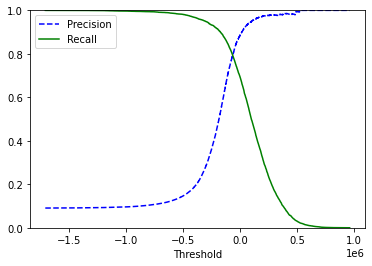

In [86]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Now we can simply select the threshold value that gives the best precision/recall tradeoff for our task.